In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
import torch

In [81]:
df = pd.read_csv("that_combined_ticks.csv", index_col=0)

In [82]:
df.describe()

,S&P500_Close,Crude Oil_Close,Silver_Close,Iron_Close,Natural Gas_Close,NYSE Composite_Close,Chinese Yuan_Close,Candian Dollar_Close,Euro_Close,VIX_Close,Interest Rate 10y_Close,Interest Rate 30y_Close,Gold_Close
count,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000,3560.000000
mean,2801.664708,71.667081,22.179357,107.345857,3.302971,12238.771415,0.151684,0.825288,1.183869,18.100815,2.440344,3.071698,1559.344269
std,1223.372303,21.921311,6.419630,38.369227,1.264611,3118.113810,0.007919,0.102027,0.111950,6.935248,0.926548,0.817491,342.784693
min,1099.229980,-37.630001,11.735000,38.540001,1.482000,6571.450195,0.136467,0.686662,0.959619,9.140000,0.499000,0.937000,1050.800049
25%,1872.707458,52.627501,16.813250,74.565001,2.563750,10103.062744,0.145033,0.750124,1.096578,13.477500,1.787500,2.592750,1274.800049
50%,2543.099976,71.754997,20.871500,106.450001,2.936500,11804.990234,0.152458,0.778334,1.141292,16.290001,2.325000,3.019000,1493.900024
75%,3870.652527,90.985003,26.142000,133.570000,3.827250,14890.517334,0.158065,0.915634,1.281160,20.610001,2.933500,3.630250,1793.350037
max,6086.490234,123.699997,48.584000,219.770004,9.680000,20272.039062,0.170561,1.060220,1.484406,82.690002,4.988000,5.103000,2788.500000


# Scaling
Variable have different scales, thus we will scale each sepreatley 

## Walk-Forward Validation

$$(\text{Batch}, \text{Window}, \text{Variables})$$

In [83]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mm = MinMaxScaler()
ss = StandardScaler()

scaled_df = pd.DataFrame(ss.fit_transform(df), columns=df.columns)
# pd.DataFrame(mm.fit_transform(df), columns=df.columns)

In [84]:
window = 9
tscv = TimeSeriesSplit(test_size=1, n_splits=len(df)-1-(window-1), max_train_size=window)
X = []
y = []
for i, (train_index, test_index) in enumerate(tscv.split(scaled_df)):
    if i == 0:
        print("Fold", i)
        print("Train: ", train_index)
        print("Test: ", test_index)
        print()
    X.append(scaled_df.iloc[train_index].drop(columns=["Gold_Close"]).to_numpy())
    y.append(scaled_df.iloc[test_index]["Gold_Close"])

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)
train_size = int(len(y) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).float()
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert data to PyTorch tensors
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)
test_X_tensor = torch.Tensor(test_X)
test_y_tensor = torch.Tensor(test_y)

# Create DataLoader for batching
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Fold 0
Train:  [0 1 2 3 4 5 6 7 8]
Test:  [9]

(3551, 9, 12)
(3551, 1)
torch.Size([2840, 9, 12])
torch.Size([2840, 1])
torch.Size([711, 9, 12])
torch.Size([711, 1])


In [85]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit

# Define hyperparameters
window_size = 9
batch_size = 32
test_size_split = 0.2

# TimeSeriesSplit parameters
n_splits = len(df) - 1 - (window_size - 1)

# Data processing function
def prepare_data(scaled_df, window_size, target_column="Gold_Close"):
    tscv = TimeSeriesSplit(test_size=1, n_splits=n_splits, max_train_size=window_size)
    X, y = [], []

    for train_index, test_index in tscv.split(scaled_df):
        # Features: exclude the target column
        X.append(scaled_df.iloc[train_index].to_numpy())
        # Labels: include only the target column for the next day
        y.append(scaled_df.iloc[test_index][target_column].values)

    X = np.array(X)
    y = np.array(y)

    return X, y

# Split data into training and testing
def split_train_test(X, y, test_size_split):
    train_size = int(len(y) * (1 - test_size_split))
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size], y[train_size:]

    # Convert to PyTorch tensors
    train_X = torch.from_numpy(train_X).float()
    train_y = torch.from_numpy(train_y).float()
    test_X = torch.from_numpy(test_X).float()
    test_y = torch.from_numpy(test_y).float()

    return train_X, train_y, test_X, test_y

# Dataset and DataLoader preparation
def create_dataloaders(train_X, train_y, test_X, test_y, batch_size):
    train_dataset = TensorDataset(train_X, train_y)
    test_dataset = TensorDataset(test_X, test_y)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# ---- Main workflow ----

# Prepare data
X, y = prepare_data(scaled_df, window_size)

# Split data into training and testing sets
train_X, train_y, test_X, test_y = split_train_test(X, y, test_size_split)

# Create DataLoaders
train_loader, test_loader = create_dataloaders(train_X, train_y, test_X, test_y, batch_size)

# Check shapes
print(f"Training X shape: {train_X.shape}")
print(f"Training y shape: {train_y.shape}")
print(f"Testing X shape: {test_X.shape}")
print(f"Testing y shape: {test_y.shape}")

Training X shape: torch.Size([2840, 9, 13])
Training y shape: torch.Size([2840, 1])
Testing X shape: torch.Size([711, 9, 13])
Testing y shape: torch.Size([711, 1])


In [86]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size  // 2, output_size)

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, requires_grad=True)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(self.fc1(out[:, -1, :]))

        out = self.dropout(out)

        out = self.fc2(out)

        return out

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU Layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Initialize hidden state for GRU (set it to zero)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the GRU
        out, _ = self.gru(x, h0)

        # Take the output from the last time step
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        
        # Apply dropout
        out = self.dropout(out)

        # Final fully connected layer
        out = self.fc2(out)

        return out

class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, output_dim=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out

# Initialize the LSTM model
input_size = X.shape[2]
hidden_size = 256
num_layers = 1
output_size = 1

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

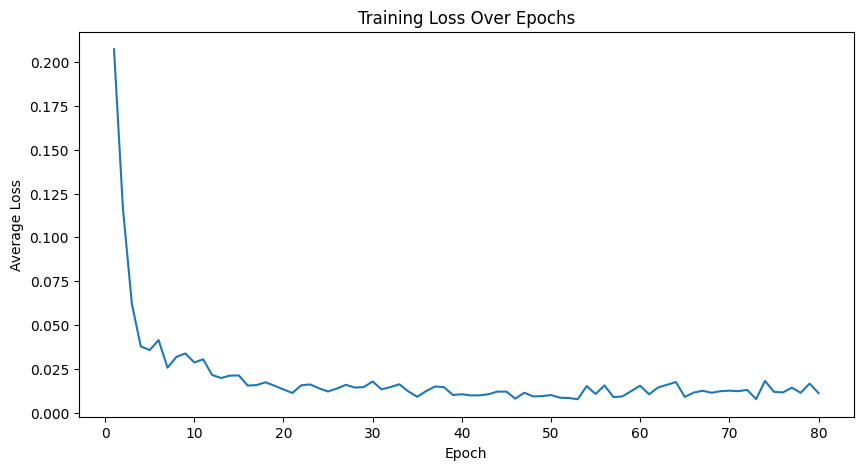

In [87]:
from tqdm.notebook import trange
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Number of epochs
num_epochs = 80

# List to store average losses
average_losses = []

# Outer loop using `trange` to track the progress of epochs
epoch_progress = trange(num_epochs, desc="Epochs")

for epoch in epoch_progress:
    model.train()
    running_loss = 0.0
    last_loss = 0.0
    
    # Iterate over batches within each epoch
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        last_loss = loss.item()  # Capture the last batch loss

    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    average_losses.append(avg_loss)  # Store the average loss for the epoch
    
    # Update the progress bar with the last loss and average loss
    epoch_progress.set_postfix({'Last Batch Loss': last_loss, 'Avg Loss': avg_loss})

# Plotting the losses after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), average_losses, linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.show()

In [88]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate the model on a given dataset (train or test)
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return np.array(all_labels), np.array(all_preds)

# Evaluate on test data
test_labels, test_preds = evaluate_model(model, test_loader)

# Evaluate on train data
train_labels, train_preds = evaluate_model(model, train_loader)



Test Data Metrics:
Mean Squared Error: 1.3204
R2 Score: -0.9752
Root Mean Squared Error: 1.1491

Train Data Metrics:
Mean Squared Error: 0.0451
R2 Score: 0.9049
Root Mean Squared Error: 0.2123


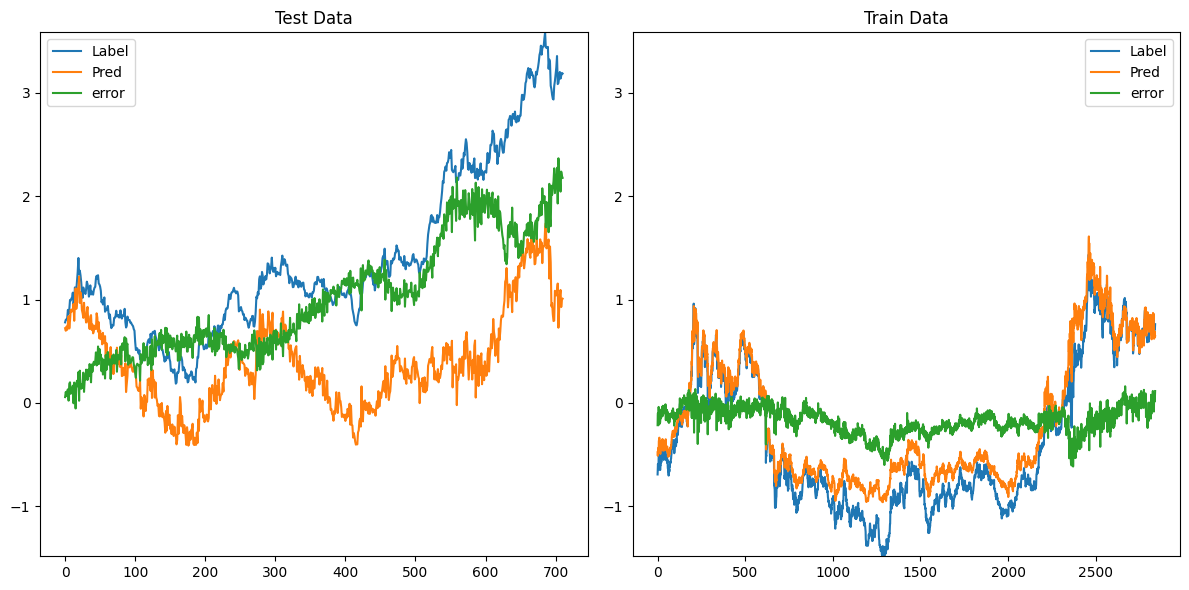

In [89]:

# Calculate metrics for the test data
test_mse = mean_squared_error(test_labels, test_preds)
test_r2 = r2_score(test_labels, test_preds)
test_rmse = np.sqrt(test_mse)

# Calculate metrics for the train data
train_mse = mean_squared_error(train_labels, train_preds)
train_r2 = r2_score(train_labels, train_preds)
train_rmse = np.sqrt(train_mse)

# Print the metrics for test data
print("Test Data Metrics:")
print(f'Mean Squared Error: {test_mse:.4f}')
print(f'R2 Score: {test_r2:.4f}')
print(f'Root Mean Squared Error: {test_rmse:.4f}')

# Print the metrics for train data
print("\nTrain Data Metrics:")
print(f'Mean Squared Error: {train_mse:.4f}')
print(f'R2 Score: {train_r2:.4f}')
print(f'Root Mean Squared Error: {train_rmse:.4f}')

# Find the global min and max for both plots
y_min = min(np.min(train_labels), np.min(train_preds), np.min(test_labels), np.min(test_preds))
y_max = max(np.max(train_labels), np.max(train_preds), np.max(test_labels), np.max(test_preds))

# Plotting both the train and test data predictions side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for test data
pd.DataFrame(np.column_stack([test_labels, test_preds, test_labels - test_preds]), columns=["Label", "Pred", "error"]).plot(ax=axs[0])
axs[0].set_title("Test Data")
axs[0].set_ylim([y_min, y_max])  # Set same scale for y-axis

# Plot for train data
pd.DataFrame(np.column_stack([train_labels, train_preds, train_labels - train_preds]), columns=["Label", "Pred", "error"]).plot(ax=axs[1])
axs[1].set_title("Train Data")
axs[1].set_ylim([y_min, y_max])  # Set same scale for y-axis

plt.tight_layout()
plt.show()

In [90]:
scaled_pred = pd.DataFrame(np.column_stack([test_X[:, 0, :12], test_preds]), columns=df.columns)
unscaled_pred = pd.DataFrame(ss.inverse_transform(scaled_pred), columns=scaled_df.columns)

unscaled_pred

,S&P500_Close,Crude Oil_Close,Silver_Close,Iron_Close,Natural Gas_Close,NYSE Composite_Close,Chinese Yuan_Close,Candian Dollar_Close,Euro_Close,VIX_Close,Interest Rate 10y_Close,Interest Rate 30y_Close,Gold_Close
0,4349.930176,87.349998,23.806999,129.399994,4.277,16236.509766,0.158065,0.792651,1.130454,31.959999,1.848,2.167,1807.219116
1,4326.509766,86.610001,22.673000,129.960007,6.265,16152.120117,0.158238,0.789983,1.124354,30.490000,1.807,2.091,1798.714600
2,4431.850098,86.820000,22.302000,130.809998,4.639,16397.859375,0.157062,0.784578,1.114703,27.660000,1.782,2.083,1812.683350
3,4515.549805,88.150002,22.395000,131.149994,4.874,16659.769531,0.157456,0.783754,1.115237,24.830000,1.782,2.098,1801.994385
4,4546.540039,88.199997,22.596001,138.789993,4.751,16829.720703,0.157245,0.786324,1.122965,21.959999,1.800,2.124,1822.872925
...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,5870.620117,67.019997,30.371000,101.629997,2.823,19645.769531,0.138328,0.711162,1.053008,16.139999,4.428,4.601,1914.190186
707,5893.620117,69.160004,31.163000,101.760002,2.973,19718.419922,0.138293,0.709930,1.053375,15.580000,4.414,4.606,1934.040405
708,5916.979980,69.389999,31.208000,101.889999,2.998,19718.250000,0.138209,0.713145,1.059490,16.350000,4.379,4.565,1877.473511
709,5917.109863,68.870003,30.955999,101.949997,3.193,19749.130859,0.138158,0.716589,1.060760,17.160000,4.406,4.592,1900.983032


In [91]:
scaled_true = pd.DataFrame(np.column_stack([test_X[:, 0, :12], test_labels]), columns=df.columns)
unscaled_true = pd.DataFrame(ss.inverse_transform(scaled_true), columns=scaled_df.columns)

unscaled_true

,S&P500_Close,Crude Oil_Close,Silver_Close,Iron_Close,Natural Gas_Close,NYSE Composite_Close,Chinese Yuan_Close,Candian Dollar_Close,Euro_Close,VIX_Close,Interest Rate 10y_Close,Interest Rate 30y_Close,Gold_Close
0,4349.930176,87.349998,23.806999,129.399994,4.277,16236.509766,0.158065,0.792651,1.130454,31.959999,1.848,2.167,1826.599976
1,4326.509766,86.610001,22.673000,129.960007,6.265,16152.120117,0.158238,0.789983,1.124354,30.490000,1.807,2.091,1835.199951
2,4431.850098,86.820000,22.302000,130.809998,4.639,16397.859375,0.157062,0.784578,1.114703,27.660000,1.782,2.083,1836.199951
3,4515.549805,88.150002,22.395000,131.149994,4.874,16659.769531,0.157456,0.783754,1.115237,24.830000,1.782,2.098,1840.800049
4,4546.540039,88.199997,22.596001,138.789993,4.751,16829.720703,0.157245,0.786324,1.122965,21.959999,1.800,2.124,1868.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,5870.620117,67.019997,30.371000,101.629997,2.823,19645.769531,0.138328,0.711162,1.053008,16.139999,4.428,4.601,2657.000000
707,5893.620117,69.160004,31.163000,101.760002,2.973,19718.419922,0.138293,0.709930,1.053375,15.580000,4.414,4.606,2634.899902
708,5916.979980,69.389999,31.208000,101.889999,2.998,19718.250000,0.138209,0.713145,1.059490,16.350000,4.379,4.565,2644.699951
709,5917.109863,68.870003,30.955999,101.949997,3.193,19749.130859,0.138158,0.716589,1.060760,17.160000,4.406,4.592,2653.800049


In [94]:
final = pd.DataFrame({
    "Actual": unscaled_true['Gold_Close'],
    "Predicted": unscaled_pred["Gold_Close"]
})
final

,Actual,Predicted
0,1826.599976,1807.219116
1,1835.199951,1798.714600
2,1836.199951,1812.683350
3,1840.800049,1801.994385
4,1868.000000,1822.872925
...,...,...
706,2657.000000,1914.190186
707,2634.899902,1934.040405
708,2644.699951,1877.473511
709,2653.800049,1900.983032


In [97]:
final.to_csv("LSTM_comparison.csv", index=False)